In [212]:
import os.path

import episcanpy as epi
import scanpy as sc
import numpy as np
import anndata as ad
import pandas as pd
from scipy.sparse import issparse, csr_matrix, csc_matrix, hstack
import tempfile
import requests
import warnings

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

import utils


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### File Paths

In [152]:
mixed_tissue = False
h5ad_path = "/mnt/workspace_stud/mbentse/catlas_objects/heart_lv_SM-IOBHO.h5ad"
out_filename = "heart_lv_SM-IOBHO"

In [153]:
data_folder = "/mnt/workspace_stud/allstud/wp1/data"
out_file = f"{data_folder}/2024_02_17/{out_filename}.h5ad"

metadata_url = "http://catlas.org/catlas_downloads/humantissues/Cell_metadata.tsv.gz"
metadata_filename = "Cell_metadata.tsv"
metadata_path = f"{data_folder}/catlas_metadata/{metadata_filename}"
ontology_path = f"{data_folder}/Cell_ontology.tsv"
ontology_url = "https://www.ebi.ac.uk/ols4/api/ontologies/cl/terms/http%253A%252F%252Fpurl.obolibrary.org%252Fobo%252F"

gtf_url="https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_38/gencode.v38.annotation.gtf.gz"
gtf_filename="gencode.v38.annotation.gtf"
gtf_path=f"{data_folder}/{gtf_filename}"

uropa_path = "~/.conda/envs/datenanalyse/bin/uropa"
tmpdirobj = tempfile.TemporaryDirectory()
tmpdir = tmpdirobj.name
bed_path = f"{tmpdir}/{out_filename}.bed"
uropa_config = f"{tmpdir}/config.json"
uropa_output = f"{tmpdir}/{out_filename}_finalhits.txt"

In [154]:
if not mixed_tissue:
    adata = epi.read_h5ad(h5ad_path)

In [155]:
adata.X

<9210x1154611 sparse matrix of type '<class 'numpy.float32'>'
	with 27521525 stored elements in Compressed Sparse Row format>

In [156]:
sc.pp.calculate_qc_metrics(adata=adata, percent_top=None, inplace=True)

### 2. Cell and Feature Filtering

In [157]:
epi.pp.binarize(adata)

In [158]:
adata.X.shape

(9210, 1154611)

In [159]:
# Quality filtering / remove completely empty columns/rows
epi.pp.filter_cells(adata, min_features=1)
epi.pp.filter_features(adata, min_cells=1)

In [160]:
adata.X.shape

(9210, 1117343)

#### 2.1 Cell filtering

In [161]:
# peaks_by_cell : Contains one entry per cell, the count of features 
peaks_by_cell = np.sum(adata.X, axis=1).tolist()
peaks_by_cell = [feature.pop() for feature in peaks_by_cell]

num_of_cells = len(peaks_by_cell)
cell_cutoff = round((num_of_cells/100)*1.5)

# Determine the Feature-threshold if you want to cut-off 1.5% of the highest features
upper_feature_threshold = sorted(peaks_by_cell)[-cell_cutoff]


In [162]:
# Filter cell outliers based on counts and numbers of genes expressed.
# For instance, only keep cells with at least min_counts counts or min_features genes expressed. 
# This is to filter measurement outliers, i.e. “unreliable” observations.

epi.pp.filter_cells(adata, min_features= 100)
epi.pp.filter_cells(adata, max_features= upper_feature_threshold)
adata

AnnData object with n_obs × n_vars = 9073 × 1117343
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'nb_features'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

#### 2.2 Featuring filtering

In [163]:
# peaks_by_feature: Contains one entry per feature, the count of peaks that have this feature
peaks_by_feature = np.sum(adata.X, axis=0).tolist().pop() #calculate for each feature in how many cell it is open

lower_feature_cutoff = round((len(peaks_by_feature)/100)*2)
upper_feature_cutoff = round((len(peaks_by_feature)/100)*98)

lower_cell_threshold = round( sorted(peaks_by_feature)[lower_feature_cutoff], 3 )
upper_cell_threshold = round( sorted(peaks_by_feature)[upper_feature_cutoff], 3 )

In [164]:
# Filter features based on number of cells or counts.
# Keep features that have at least min_counts counts or are expressed in at least min_cells cells
# or have at most max_counts counts or are expressed in at most max_cells cells.

epi.pp.filter_features(adata, min_cells= lower_cell_threshold)
epi.pp.filter_features(adata, max_cells= upper_cell_threshold)
adata

AnnData object with n_obs × n_vars = 9073 × 1091165
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'nb_features'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

### Load Metadata

In [165]:
utils.download(metadata_path, metadata_url)

/mnt/workspace_stud/allstud/wp1/data/catlas_metadata/Cell_metadata.tsv already exists.


In [166]:
utils.load_metadata(adata, metadata_path, columns_to_keep=['cell type'])

In [167]:
ontology_df = pd.read_csv(ontology_path, delimiter="\t")
ontology_df = ontology_df.rename(columns={
    "Cell type": "cell type", 
    "closest Cell Ontology term(s)": "ontology label",
    "Cell Ontology ID": "ontology id"})
index_list = adata.obs_names
adata.obs = pd.merge(adata.obs, ontology_df, how="left", on="cell type")
adata.obs_names = index_list

In [168]:
# 10% of all cells:
len(adata.obs["ontology label"])

9073

In [169]:
adata.obs["ontology label"].value_counts()

ontology label
ventricular cardiac muscle cell         4452
fibroblast of cardiac tissue            2229
macrophage                               508
cardiac endothelial cell                 467
pericyte cell                            420
endocardial cell                         380
endothelial cell                         221
fibroblast                               113
schwann cell                              93
CD8-positive, alpha-beta T cell           62
alveolar macrophage                       59
endothelial cell of lymphatic vessel      17
smooth muscle cell                        15
regular atrial cardiac myocyte            12
mature NK T cell                           8
naive t cell                               5
plasma cell                                3
blood vessel smooth muscle cell            2
CD4-positive, alpha-beta T cell            2
mast cell                                  2
fat cell                                   1
luteal cell                             

### Ontology Filtering

In [170]:
# only keep labels that are bigger than 1% of cell count
threshold = len(adata.obs["ontology label"]) / 100.0
counts = adata.obs["ontology label"].value_counts()
valid_labels = counts[counts >= threshold].index
adata = adata[adata.obs["ontology label"].isin(valid_labels)].copy()

In [172]:
adata.obs["ontology label"].value_counts()

ontology label
ventricular cardiac muscle cell    4452
fibroblast of cardiac tissue       2229
macrophage                          508
cardiac endothelial cell            467
pericyte cell                       420
endocardial cell                    380
endothelial cell                    221
fibroblast                          113
schwann cell                         93
Name: count, dtype: int64

### Uropa annotation

In [173]:
utils.download(gtf_path, gtf_url)

/mnt/workspace_stud/allstud/wp1/data/gencode.v38.annotation.gtf already exists.


In [174]:
def parse_region(region):
    if ':' in region and '-' in region:
        chrom, positions = region.split(':')
        begin, end = map(int, positions.split('-'))
    elif '_' in region:
        chrom, begin, end = region.split('_')
        begin, end = int(begin), int(end)
    else:
        raise ValueError(f"Invalid region format: {region}")
    return chrom, begin, end

with open(bed_path, "w") as f:
    for region in adata.var_names.tolist():
        chrom, begin, end = parse_region(region)
        f.write(f"{chrom}\t{begin}\t{end}\n")
    f.flush()

In [175]:
%%bash -s {tmpdir} {uropa_config} {gtf_path} {bed_path}
cat >$2 << EOF
{
"queries":[
    {
        "distance": [5000, 2000],
        "feature": ["gene"],
        "feature_anchor": ["end", "start", "center"]
    }
],
"show_attributes": ["gene_name"],
"priority": "False",
"gtf": "$3",
"bed": "$4",
"outdir": "$1",
"threads": "$(nproc --all)"
}
EOF

In [176]:
%%time
!{uropa_path} -i {uropa_config}

2024-02-22 13:25:11 (1166494) [INFO]	Started UROPA 4.0.3
2024-02-22 13:25:11 (1166494) [INFO]	Working directory: /home/stud2/notebooks
2024-02-22 13:25:11 (1166494) [INFO]	Command-line call: /home/stud2/.conda/envs/datenanalyse/bin/uropa -i /tmp/tmpf3arlf69/config.json
2024-02-22 13:25:11 (1166494) [INFO]	Reading configuration from commandline/input config
2024-02-22 13:25:11 (1166494) [INFO]	Preparing .gtf-file for fast access
2024-02-22 13:25:56 (1166494) [INFO]	Started annotation
2024-02-22 13:26:02 (1166494) [INFO]	Progress: Annotated 35000 peaks (0 jobs running; 35 jobs finished)
2024-02-22 13:26:07 (1166494) [INFO]	Progress: Annotated 85000 peaks (0 jobs running; 85 jobs finished)
2024-02-22 13:26:12 (1166494) [INFO]	Progress: Annotated 135000 peaks (0 jobs running; 135 jobs finished)
2024-02-22 13:26:17 (1166494) [INFO]	Progress: Annotated 185000 peaks (0 jobs running; 185 jobs finished)
2024-02-22 13:26:22 (1166494) [INFO]	Progress: Annotated 235000 peaks (0 jobs running; 235 j

In [177]:
uropa_df = pd.read_csv(uropa_output, delimiter="\t")
uropa_df['index'] = uropa_df['peak_chr'].astype(str) + ':' + uropa_df['peak_start'].astype(str) + '-' + uropa_df['peak_end'].astype(str)
uropa_df = uropa_df[['index', 'gene_name']]
uropa_df = uropa_df.set_index('index')
adata.var = adata.var.merge(uropa_df, left_index=True, right_index=True)

In [178]:
tmpdirobj.cleanup()

### PCA, UMAP and Clustering

In [180]:
sc.pp.normalize_total(adata, exclude_highly_expressed=False, target_sum=None)
sc.pp.log1p(adata)

In [181]:
%%time
sc.pp.pca(adata, n_comps=25, use_highly_variable=False)

CPU times: user 2min 37s, sys: 5min 46s, total: 8min 23s
Wall time: 1min 38s


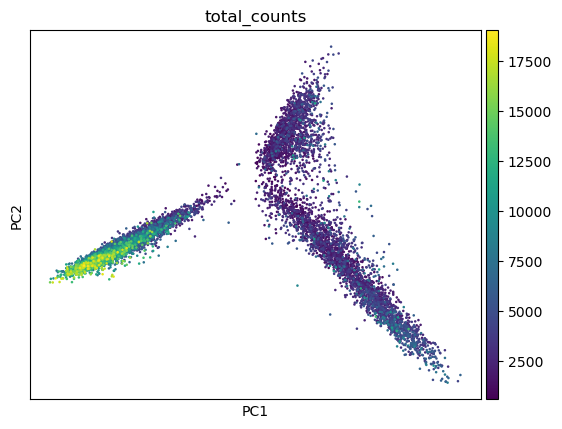

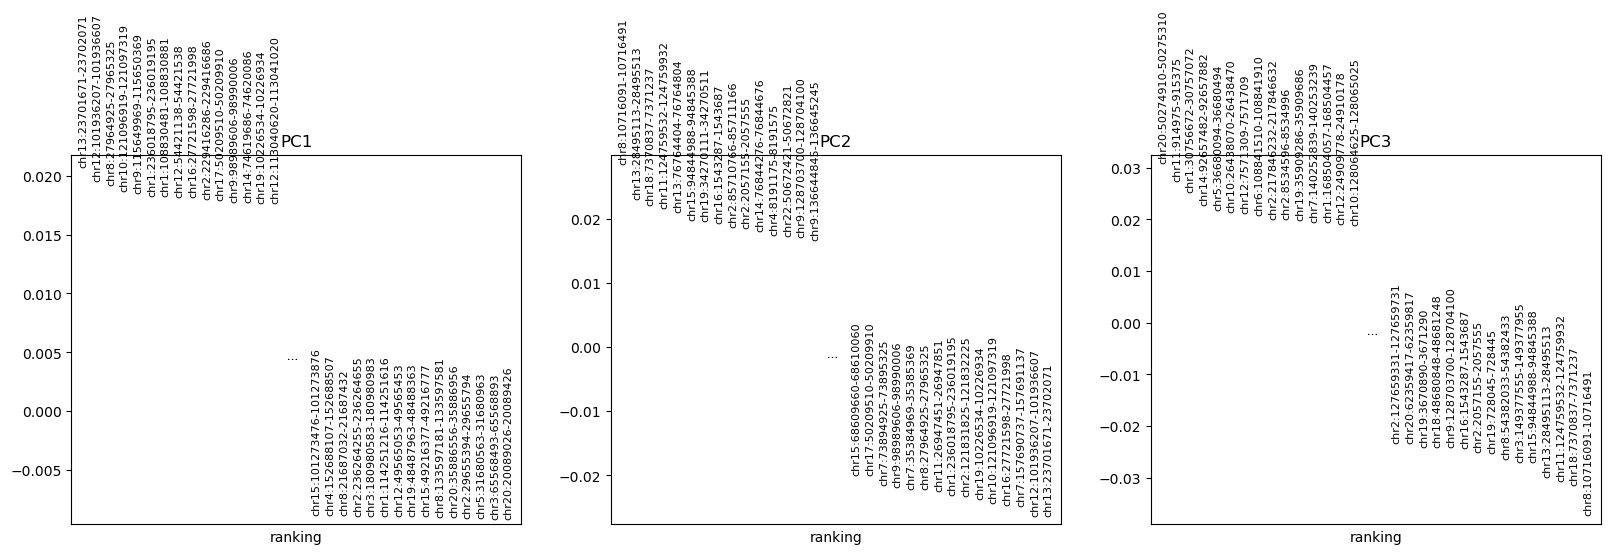

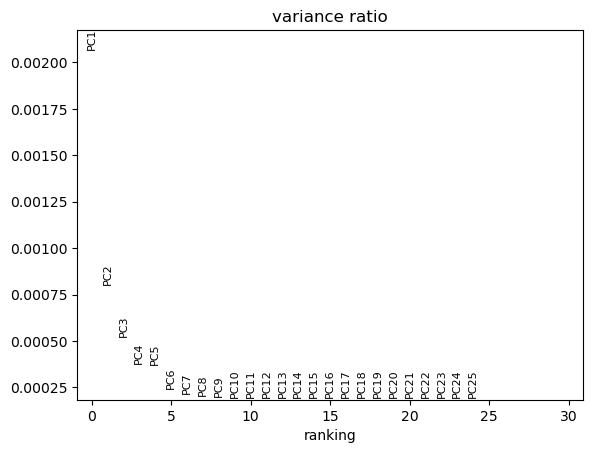

In [182]:
sc.pl.pca_overview(adata, color="total_counts")

In [183]:
%%time
sc.pp.neighbors(adata, n_neighbors=15, method='umap', metric='euclidean')

CPU times: user 35.3 s, sys: 1.04 s, total: 36.4 s
Wall time: 34.7 s


In [184]:
%%time
sc.tl.umap(adata, min_dist=0.1, spread=2.5)

CPU times: user 18 s, sys: 959 ms, total: 19 s
Wall time: 17.7 s


<Axes: title={'center': 'log1p_n_genes_by_counts'}, xlabel='UMAP1', ylabel='UMAP2'>

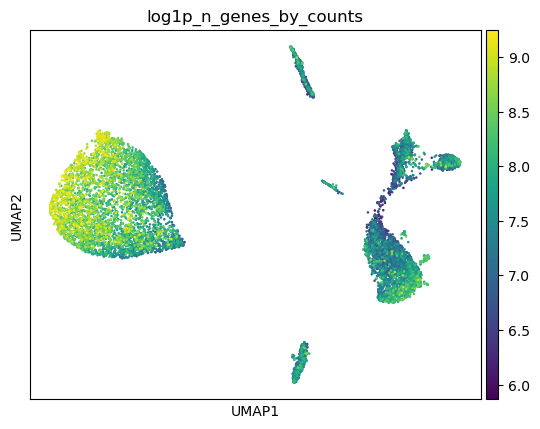

In [185]:
sc.pl.embedding(adata, basis='umap', ncols=3, show=False, color="log1p_n_genes_by_counts")

In [285]:
%%time
if "clusters" not in adata.uns:
    adata.uns["clusters"] = dict()


params = [
    ['louvain_0.1',
     'louvain_0.25',
     'louvain_0.5',
     'louvain_1',
     'leiden_0.1',
     'leiden_0.25',
     'leiden_0.5',
     'leiden_1',
     'kmeans_7',
     'kmeans_10',
     'kmeans_13',
     'kmeans_16',]
]


ragi_reference = utils.ragi(adata, 'ontology label')
adata.uns["ragi_reference"] = ragi_reference

for method, value in params:
    tag = f'{method}_{value}'
    
    if method == 'louvain':
        sc.tl.louvain(adata, resolution=value, key_added=tag)
    elif method == 'leiden':
        sc.tl.leiden(adata, resolution=value, key_added=tag)
    elif method == 'kmeans':
        epi.tl.kmeans(adata, num_clusters=value)
        adata.obs[tag] = adata.obs["kmeans"]
        del adata.obs["kmeans"]
        adata.obs[tag] = adata.obs[tag].astype(str)
        adata.obs[tag] = adata.obs[tag].astype('category')
    else:
        print("unknown method: {method}")
        
    # calculate scores
    ari = epi.tl.ARI(adata, tag, 'ontology label')
    ami = epi.tl.AMI(adata, tag, 'ontology label')
    ragi = utils.ragi(adata, tag)
    
    adata.uns["clusters"][tag] = {
        "method": method,
        "param": {
           "n_clusters" if method == "kmeans" else "resolution": value 
        },
        "score": {
            "ari": ari,
            "ami": ami,
            "ragi": ragi
        }
    }

CPU times: user 3min 52s, sys: 7.89 s, total: 4min
Wall time: 3min 45s


In [286]:
adata.uns["clusters"]

{'louvain_0.1': {'method': 'louvain',
  'param': {'resolution': 0.1},
  'score': {'ari': 0.9437233709954683,
   'ami': 0.8857506322969518,
   'ragi': 0.6563980791049}},
 'louvain_0.25': {'method': 'louvain',
  'param': {'resolution': 0.25},
  'score': {'ari': 0.6374671431546887,
   'ami': 0.8023777453173078,
   'ragi': 0.6721649046765077}},
 'louvain_0.5': {'method': 'louvain',
  'param': {'resolution': 0.5},
  'score': {'ari': 0.5653997971474842,
   'ami': 0.7671197950649642,
   'ragi': 0.6889403712860506}},
 'louvain_1': {'method': 'louvain',
  'param': {'resolution': 1},
  'score': {'ari': 0.33544029918448354,
   'ami': 0.6871392343337897,
   'ragi': 0.7163538205277022}},
 'leiden_0.1': {'method': 'leiden',
  'param': {'resolution': 0.1},
  'score': {'ari': 0.9549464197752866,
   'ami': 0.9000293686883964,
   'ragi': 0.7108772576332166}},
 'leiden_0.25': {'method': 'leiden',
  'param': {'resolution': 0.25},
  'score': {'ari': 0.6399584091666934,
   'ami': 0.8003943037707781,
   'rag

In [265]:
# calculate best ari cluster:
best_tag, best_ari = None, 0
for tag in adata.uns["clusters"]:
    ari = adata.uns["clusters"][tag]["score"]["ari"]
    if ari > best_ari:
        best_tag = tag
        best_ari = ari
print(best_tag, best_ari)
adata.uns["best_cluster"] = best_tag

leiden_0.1 0.9549464197752866


In [204]:
# calculate best ragi cluster:
best_tag, best_ragi = None, 0
for tag in adata.uns["clusters"]:
    ragi = adata.uns["clusters"][tag]["score"]["ragi"]
    if ragi > best_ragi:
        best_tag = tag
        best_ragi = ragi
print(best_tag, best_ragi)
adata.uns["best_cluster_ragi"] = best_tag

kmeans_16 0.8080980523371619


<Axes: title={'center': 'leiden_0.1'}, xlabel='UMAP1', ylabel='UMAP2'>

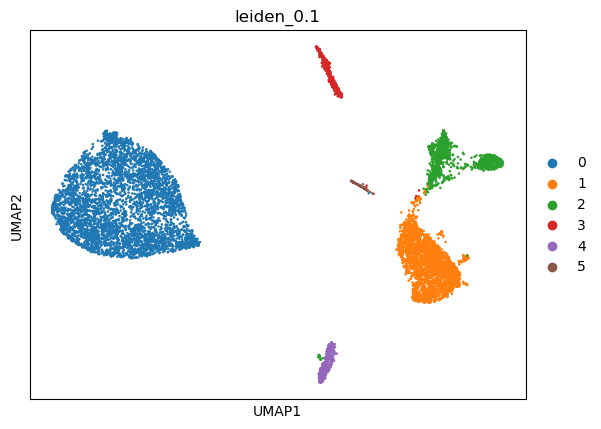

In [295]:
sc.pl.embedding(adata, basis='umap', ncols=3, show=False, color=adata.uns["best_cluster"])

<Axes: title={'center': 'ontology label'}, xlabel='UMAP1', ylabel='UMAP2'>

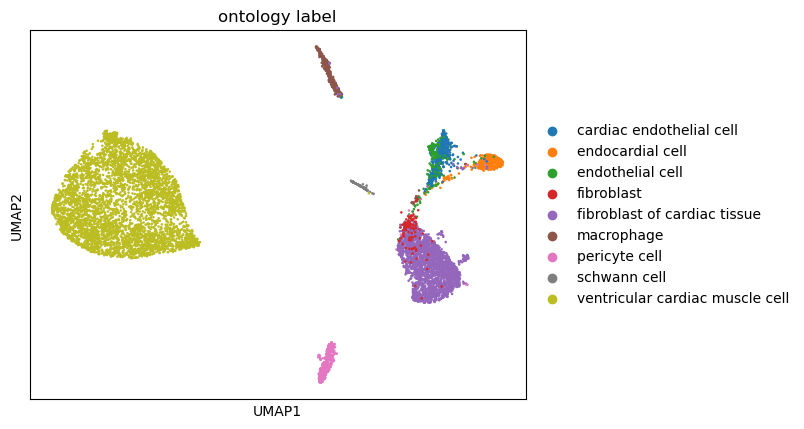

In [298]:
sc.pl.embedding(adata, basis='umap', ncols=3, show=False, color=["ontology label"])

__Rekey adata.var to genes__

#### remove unannotated regions

In [305]:
adata = adata[:, ~adata.var['gene_name'].isna()]

In [306]:
adata_csc = adata.X.tocsc()

In [308]:
%%time
merged_data_dict = {}

for gene in adata.var["gene_name"].unique():
    # calulate for this gene the indices of the associated regions
    gene_regions = np.flatnonzero(adata.var['gene_name'] == gene)

    # get the data from adata.X for the regions
    data_slice = adata_csc[:, gene_regions]

    # merge the regions together with max
    # This will take for each cell the max value of the regions associated with this gene.
    # Thus the peaks of the regions are effectively merged
    # So if one region has no peak (value = 0) and two other regions have a peak
    # we will take the value from the higher peak.
    merged = data_slice.max(axis=1)
    merged_data_dict[gene] = merged

In [309]:
merged_matrix = hstack(list(merged_data_dict.values()), format='csr')

In [310]:
adata_merged = ad.AnnData(
    X=merged_matrix, 
    obs=adata.obs, 
    obsm=adata.obsm, 
    var=adata.var.groupby(by="gene_name").aggregate({ f"{c}_gini_scores": "max" for c in adata.uns["clusters"]})
)
adata_merged.uns.update(adata.uns)

In [311]:
%%time
adata_merged.write(
        out_file,
        compression="gzip")

CPU times: user 1.48 s, sys: 31.8 ms, total: 1.51 s
Wall time: 1.55 s


In [318]:
adata_merged

AnnData object with n_obs × n_vars = 8883 × 51376
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'nb_features', 'cell type', 'ontology label', 'ontology id', 'louvain_0.1', 'louvain_0.25', 'louvain_0.5', 'louvain_1', 'leiden_0.1', 'leiden_0.25', 'leiden_0.5', 'leiden_1', 'kmeans_13', 'kmeans_16', 'kmeans_7', 'kmeans_10'
    var: 'louvain_0.1_gini_scores', 'louvain_0.25_gini_scores', 'louvain_0.5_gini_scores', 'louvain_1_gini_scores', 'leiden_0.1_gini_scores', 'leiden_0.25_gini_scores', 'leiden_0.5_gini_scores', 'leiden_1_gini_scores', 'kmeans_13_gini_scores', 'kmeans_16_gini_scores', 'kmeans_7_gini_scores', 'kmeans_10_gini_scores'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'clusters', 'ragi_reference', 'louvain', 'leiden', 'best_cluster_ragi', 'best_cluster', 'leiden_0.1_colors', 'kmeans_7_colors', 'ontology label_colors'
    obsm: 'X_pca', 'X_umap'

In [313]:
adata.uns["clusters"]

{'louvain_0.1': {'method': 'louvain',
  'param': {'resolution': 0.1},
  'score': {'ari': 0.9437233709954683,
   'ami': 0.8857506322969518,
   'ragi': 0.6563980791049}},
 'louvain_0.25': {'method': 'louvain',
  'param': {'resolution': 0.25},
  'score': {'ari': 0.6374671431546887,
   'ami': 0.8023777453173078,
   'ragi': 0.6721649046765077}},
 'louvain_0.5': {'method': 'louvain',
  'param': {'resolution': 0.5},
  'score': {'ari': 0.5653997971474842,
   'ami': 0.7671197950649642,
   'ragi': 0.6889403712860506}},
 'louvain_1': {'method': 'louvain',
  'param': {'resolution': 1},
  'score': {'ari': 0.33544029918448354,
   'ami': 0.6871392343337897,
   'ragi': 0.7163538205277022}},
 'leiden_0.1': {'method': 'leiden',
  'param': {'resolution': 0.1},
  'score': {'ari': 0.9549464197752866,
   'ami': 0.9000293686883964,
   'ragi': 0.7108772576332166}},
 'leiden_0.25': {'method': 'leiden',
  'param': {'resolution': 0.25},
  'score': {'ari': 0.6399584091666934,
   'ami': 0.8003943037707781,
   'rag